## Instalação das bibliotecas

In [1]:
!pip install --upgrade langchain-text-splitters langchain-community langgraph

  Obtaining dependency information for langchain-text-splitters from https://files.pythonhosted.org/packages/a2/37/b2c971dfea62675f640e0dd5a078ca502885059276d21b7143cf1fe13e82/langchain_text_splitters-0.3.4-py3-none-any.whl.metadata
  Obtaining dependency information for langchain-community from https://files.pythonhosted.org/packages/45/a7/b9f3cd12510fe9a5fe2dcd7f12d095b0d5bd95fb2cd9c5362de45ebc18f9/langchain_community-0.3.13-py3-none-any.whl.metadata
  Obtaining dependency information for langgraph from https://files.pythonhosted.org/packages/93/ce/150789d181ea0570112c6fae330f477aa5f68fa425098c25c2c9b1556676/langgraph-0.2.60-py3-none-any.whl.metadata
  Obtaining dependency information for langchain-core<0.4.0,>=0.3.26 from https://files.pythonhosted.org/packages/9a/bf/07e63d4b4c41aa49daf4a4499e8010928ce8545469f0265544f925c95fff/langchain_core-0.3.28-py3-none-any.whl.metadata
  Obtaining dependency information for httpx-sse<0.5.0,>=0.4.0 from https://files.pythonhosted.org/packages/e1

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
clarifai 9.8.1 requires tqdm==4.64.1, but you have tqdm 4.66.4 which is incompatible.
jupyter-server 1.13.5 requires pywinpty<2; os_name == "nt", but you have pywinpty 2.0.10 which is incompatible.


In [2]:
!pip install -U langchain-openai

  Obtaining dependency information for langchain-openai from https://files.pythonhosted.org/packages/ed/54/63c8264d7dbc3bf31ba61bf97740fdd76386b2d4f9a58f58afd3961ce7d7/langchain_openai-0.2.14-py3-none-any.whl.metadata
  Obtaining dependency information for openai<2.0.0,>=1.58.1 from https://files.pythonhosted.org/packages/8e/5a/d22cd07f1a99b9e8b3c92ee0c1959188db4318828a3d88c9daac120bdd69/openai-1.58.1-py3-none-any.whl.metadata
  Obtaining dependency information for jiter<1,>=0.4.0 from https://files.pythonhosted.org/packages/4e/1e/7f96b798f356e531ffc0f53dd2f37185fac60fae4d6c612bbbd4639b90aa/jiter-0.8.2-cp311-cp311-win_amd64.whl.metadata
   ---------------------------------------- 0.0/50.9 kB ? eta -:--:--
   ---------------------------------------- 50.9/50.9 kB 1.3 MB/s eta 0:00:00
   ---------------------------------------- 0.0/454.3 kB ? eta -:--:--
   --------------------------------------- 454.3/454.3 kB 29.6 MB/s eta 0:00:00
   ---------------------------------------- 0.0/206.7 kB

Importando modelo

In [1]:
import os
from langchain_openai import ChatOpenAI

if not os.environ.get("OPENAI_API_KEY"):
    os.environ["OPENAI_API_KEY"] = os.environ.get('OPEN_AI_KEY')

llm = ChatOpenAI(model="gpt-4o-mini")

Importando embeeding: O embeeding converte texto em vetor

In [2]:
import os

if not os.environ.get("OPENAI_API_KEY"):
    os.environ["OPENAI_API_KEY"] = os.environ.get('OPEN_AI_KEY')
    
from langchain_openai import OpenAIEmbeddings

embeddings = OpenAIEmbeddings(model="text-embedding-3-large")

Importa um Vector Store: Ele é que faz a busca no texto que você fez embeeding

In [3]:
from langchain_core.vectorstores import InMemoryVectorStore

vector_store = InMemoryVectorStore(embeddings)

Neste trecho vai carregar o site e dividir o conteúdo do texto do site que se fará RAG em chunks de tamanho 1000 

In [4]:
import bs4
from langchain import hub
from langchain_community.document_loaders import WebBaseLoader
from langchain_core.documents import Document
from langchain_text_splitters import RecursiveCharacterTextSplitter
from langgraph.graph import START, StateGraph
from typing_extensions import List, TypedDict

# Já faz o filtro do que realmente importa extrair do site.
bs4_strainer = bs4.SoupStrainer(class_=("post-title", "post-header", "post-content"))

# Load and chunk contents of the blog
loader = WebBaseLoader(
    web_paths=("https://lilianweng.github.io/posts/2023-06-23-agent/",),
    bs_kwargs={"parse_only": bs4_strainer},
)

docs = loader.load()

text_splitter = RecursiveCharacterTextSplitter(chunk_size=1000, chunk_overlap=200)
all_splits = text_splitter.split_documents(docs)

USER_AGENT environment variable not set, consider setting it to identify your requests.


In [5]:
print(f"Split blog post into {len(all_splits)} sub-documents.")

Split blog post into 66 sub-documents.


Visualizando o arquivo

In [6]:
docs[0]

Document(metadata={'source': 'https://lilianweng.github.io/posts/2023-06-23-agent/'}, page_content='\n\n      LLM Powered Autonomous Agents\n    \nDate: June 23, 2023  |  Estimated Reading Time: 31 min  |  Author: Lilian Weng\n\n\nBuilding agents with LLM (large language model) as its core controller is a cool concept. Several proof-of-concepts demos, such as AutoGPT, GPT-Engineer and BabyAGI, serve as inspiring examples. The potentiality of LLM extends beyond generating well-written copies, stories, essays and programs; it can be framed as a powerful general problem solver.\nAgent System Overview#\nIn a LLM-powered autonomous agent system, LLM functions as the agent’s brain, complemented by several key components:\n\nPlanning\n\nSubgoal and decomposition: The agent breaks down large tasks into smaller, manageable subgoals, enabling efficient handling of complex tasks.\nReflection and refinement: The agent can do self-criticism and self-reflection over past actions, learn from mistakes

In [7]:
print(docs[0].page_content[:1000])



      LLM Powered Autonomous Agents
    
Date: June 23, 2023  |  Estimated Reading Time: 31 min  |  Author: Lilian Weng


Building agents with LLM (large language model) as its core controller is a cool concept. Several proof-of-concepts demos, such as AutoGPT, GPT-Engineer and BabyAGI, serve as inspiring examples. The potentiality of LLM extends beyond generating well-written copies, stories, essays and programs; it can be framed as a powerful general problem solver.
Agent System Overview#
In a LLM-powered autonomous agent system, LLM functions as the agent’s brain, complemented by several key components:

Planning

Subgoal and decomposition: The agent breaks down large tasks into smaller, manageable subgoals, enabling efficient handling of complex tasks.
Reflection and refinement: The agent can do self-criticism and self-reflection over past actions, learn from mistakes and refine them for future steps, thereby improving the quality of final results.


Memory

Short-term memory: I 

Armazenando os documentos numa vector store

In [8]:
# Index chunks
document_ids = vector_store.add_documents(documents=all_splits)

In [9]:
document_ids[:10]

['c025a4da-53f0-4d8b-8740-17cab7946c3b',
 '73315694-c7bd-4446-906f-88c6acd551fd',
 '7c37daed-4e00-47c6-84c6-61be83fdafa2',
 'bcb0a48e-4781-4688-9491-0ee06393ae1d',
 'c9fb48fd-bbdc-49e7-a8f0-df8d592f3df9',
 '5ccbe2e6-9e4d-4d51-898e-f2345d94da66',
 'b6d4b1f6-6498-4a42-b4fa-cd9556c2366c',
 '8124a6bc-af15-4aa9-8366-82847a69256a',
 '732789cf-2fe8-472e-931f-8f0dfe7b1e82',
 '4275749f-a196-457e-9f35-fc320f464c14']

Definir api key para o langchain pra rastreabilizar o chat abaixo

In [10]:
import os

print(os.environ.get("LANGCHAIN_TRACING_V2"))
print(os.environ.get("LANGCHAIN_API_KEY"))

True
123456


Criando o chat para a interação com o documento (RAG)

In [11]:
from langchain import hub


prompt = hub.pull("rlm/rag-prompt")

example_messages = prompt.invoke(
    {"context": "(context goes here)", "question": "(question goes here)"}
).to_messages()

assert len(example_messages) == 1
print(example_messages[0].content)

You are an assistant for question-answering tasks. Use the following pieces of retrieved context to answer the question. If you don't know the answer, just say that you don't know. Use three sentences maximum and keep the answer concise.
Question: (question goes here) 
Context: (context goes here) 
Answer:


Classe State controla o formato de entrada da mensagem para o chat

In [12]:
from langchain_core.documents import Document
from typing_extensions import List, TypedDict


class State(TypedDict):
    question: str
    context: List[Document]
    answer: str


Essas duas funções fazem:  
    Retrieve - Recupera a vector store com o contexto da pergunta enviada  
    Generate - Faz a interação do chat

In [13]:
       
def retrieve(state: State):
    retrieved_docs = vector_store.similarity_search(state["question"])
    return {"context": retrieved_docs}


def generate(state: State):
    docs_content = "\n\n".join(doc.page_content for doc in state["context"])
    messages = prompt.invoke({"question": state["question"], "context": docs_content})
    response = llm.invoke(messages)
    return {"answer": response.content}

Status de recuperação da mensagem numa RAG pela variável graph

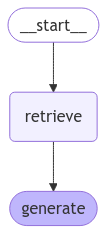

In [15]:
from langgraph.graph import START, StateGraph
from IPython.display import Image, display


graph_builder = StateGraph(State).add_sequence([retrieve, generate])
graph_builder.add_edge(START, "retrieve")
graph = graph_builder.compile()
display(Image(graph.get_graph().draw_mermaid_png()))

In [16]:
result = graph.invoke({"question": "What is Task Decomposition?"})

print(f'Context: {result["context"]}\n\n')
print(f'Answer: {result["answer"]}')

Context: [Document(id='7c37daed-4e00-47c6-84c6-61be83fdafa2', metadata={'source': 'https://lilianweng.github.io/posts/2023-06-23-agent/'}, page_content='Fig. 1. Overview of a LLM-powered autonomous agent system.\nComponent One: Planning#\nA complicated task usually involves many steps. An agent needs to know what they are and plan ahead.\nTask Decomposition#\nChain of thought (CoT; Wei et al. 2022) has become a standard prompting technique for enhancing model performance on complex tasks. The model is instructed to “think step by step” to utilize more test-time computation to decompose hard tasks into smaller and simpler steps. CoT transforms big tasks into multiple manageable tasks and shed lights into an interpretation of the model’s thinking process.'), Document(id='bcb0a48e-4781-4688-9491-0ee06393ae1d', metadata={'source': 'https://lilianweng.github.io/posts/2023-06-23-agent/'}, page_content='Tree of Thoughts (Yao et al. 2023) extends CoT by exploring multiple reasoning possibiliti